In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from random import sample


def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


def k_nearest_neighbors(train, test_row, k):
    distances = []
    
    # Проходим по каждому обучающему примеру
    for index, train_row in train.iterrows():
        dist = euclidean_distance(np.array(train_row[:-1]), np.array(test_row[:-1]))
        distances.append((train_row, dist))
    
    # Сортируем по расстоянию и выбираем k ближайших
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    
    # Получаем метки классов ближайших соседей, используя iloc
    classes = [row[0].iloc[-1] for row in neighbors]
    
    # Возвращаем наиболее частый класс
    return max(set(classes), key=classes.count)


def evaluate_knn(train, test, k):
    y_true = []
    y_pred = []

    for i, test_row in test.iterrows():
        y_true.append(test_row["Wine"])
        y_pred.append(k_nearest_neighbors(train, test_row, k))

    return confusion_matrix(y_true, y_pred)


data = pd.read_csv("WineDataset.csv")
# Проверка на отсутствующие значения
print(data.isnull().sum())

Alcohol                         0
Malic Acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
Wine                            0
dtype: int64


In [72]:
data.describe()

,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Wine
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,1.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,1.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,1.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,2.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,3.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,3.000000


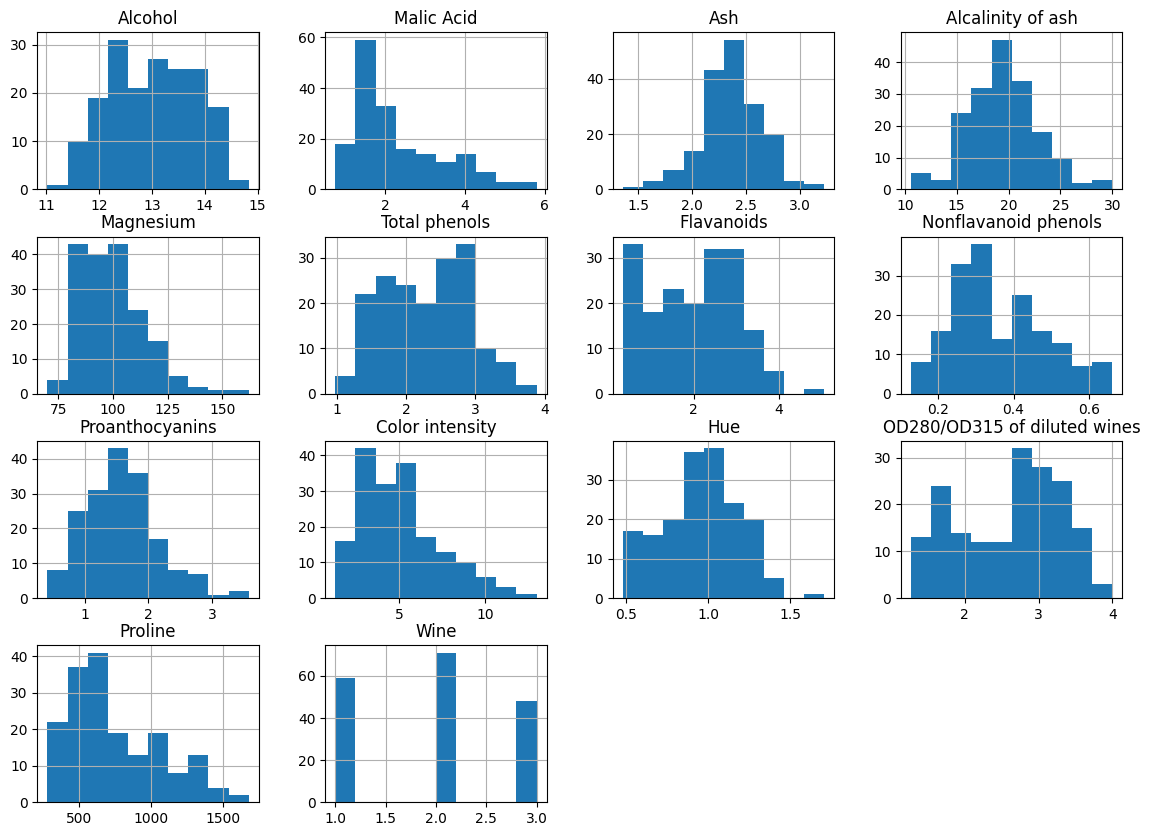

In [73]:
data.hist(figsize=(14, 10))
None

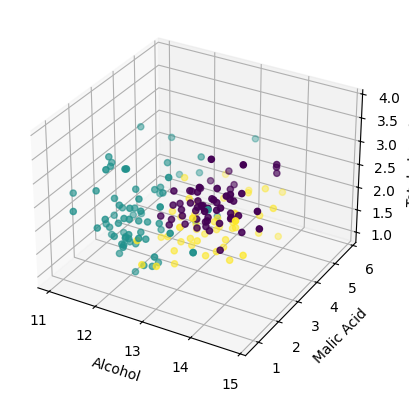

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['Alcohol'], data['Malic Acid'], data['Total phenols'], c=data['Wine'])
ax.set_xlabel('Alcohol')
ax.set_ylabel('Malic Acid')
ax.set_zlabel('Total phenols')

plt.show()

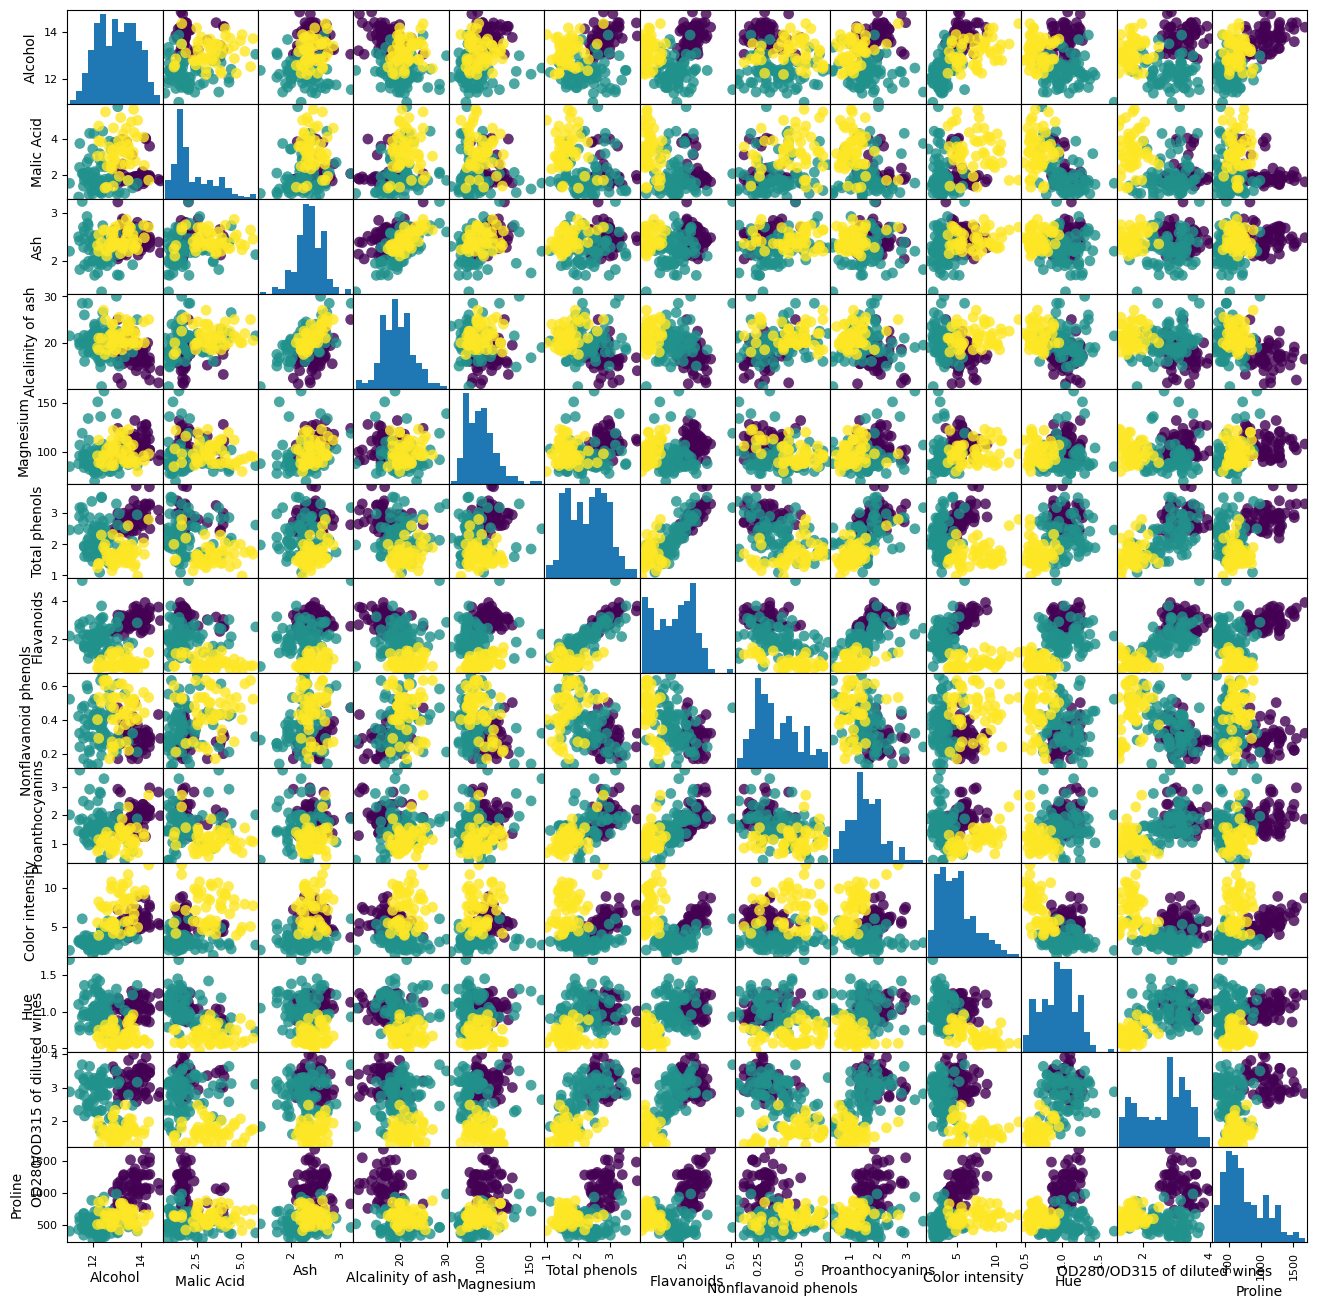

In [75]:
scatter_matrix = pd.plotting.scatter_matrix(
    data[data.columns[:-1]],  # все признаки, кроме столбца 'Wine'
    c=data['Wine'],  # цвет точек по классам
    figsize=(16, 16),
    marker='o',
    hist_kwds={'bins': 15},
    s=60,
    alpha=0.8
)

plt.show()

### Нормализация

In [76]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(data.drop('Wine', axis=1)), columns=data.columns[:-1])
data_scaled = pd.concat([X_scaled, data['Wine']], axis=1)

In [79]:
train_data = data_scaled.sample(frac=0.8, random_state=2)
test_data = data_scaled.drop(train_data.index)

# Модель 1: Случайный выбор признаков
random_features = sample(list(data_scaled.columns[:-1]), 3)
train_random = train_data[random_features + ['Wine']]
test_random = test_data[random_features + ['Wine']]

# Модель 2: Фиксированный набор признаков
fixed_features = ['Alcohol', 'Malic Acid', 'Ash']
train_fixed = train_data[fixed_features + ['Wine']]
test_fixed = test_data[fixed_features + ['Wine']]

# Оценка моделей на тестовом наборе данных при разных значениях k
k_values = [3, 5, 10]
for k in k_values:
    correct_random = 0
    correct_fixed = 0
    
    # Модель 1
    for i, test_row in test_random.iterrows():
        prediction = k_nearest_neighbors(train_random, test_row, k)
        if prediction == test_row['Wine']:
            correct_random += 1
    
    # Модель 2
    for i, test_row in test_fixed.iterrows():
        prediction = k_nearest_neighbors(train_fixed, test_row, k)
        if prediction == test_row['Wine']:
            correct_fixed += 1
    
    accuracy_random = correct_random / len(test_random)
    accuracy_fixed = correct_fixed / len(test_fixed)
    
    print(f'Model 1 (random features), k={k}: Accuracy={accuracy_random:.2f}')
    print(f'Model 2 (fixed features), k={k}: Accuracy={accuracy_fixed:.2f}')

Model 1 (random features), k=3: Accuracy=1.00
Model 2 (fixed features), k=3: Accuracy=0.75
Model 1 (random features), k=5: Accuracy=0.97
Model 2 (fixed features), k=5: Accuracy=0.78
Model 1 (random features), k=10: Accuracy=0.97
Model 2 (fixed features), k=10: Accuracy=0.81


In [80]:
for k in k_values:
    print(f'Confusion Matrix for Model 1 (random features), k={k}:')
    print(evaluate_knn(train_random, test_random, k))
    
    print(f'Confusion Matrix for Model 2 (fixed features), k={k}:')
    print(evaluate_knn(train_fixed, test_fixed, k))

Confusion Matrix for Model 1 (random features), k=3:
[[14  0  0]
 [ 0 15  0]
 [ 0  0  7]]
Confusion Matrix for Model 2 (fixed features), k=3:
[[12  0  2]
 [ 1 11  3]
 [ 3  0  4]]
Confusion Matrix for Model 1 (random features), k=5:
[[14  0  0]
 [ 1 14  0]
 [ 0  0  7]]
Confusion Matrix for Model 2 (fixed features), k=5:
[[11  0  3]
 [ 1 12  2]
 [ 2  0  5]]
Confusion Matrix for Model 1 (random features), k=10:
[[14  0  0]
 [ 1 14  0]
 [ 0  0  7]]
Confusion Matrix for Model 2 (fixed features), k=10:
[[13  0  1]
 [ 1 12  2]
 [ 3  0  4]]
